# **Optimisation**


In [1]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from typing import Literal
from queue import Queue, LifoQueue, PriorityQueue

print(os.getcwd())
os.chdir("../utils/")
sys.path.append("../utils/optimisation.py")

from optimisation import create_grid, valid_actions

plt.rcParams['figure.figsize'] = 12, 12

/Users/ninovation/Projects/Software/SourceCode/Aeternalis-Ingenium/Drone-Flight-Planning/src/notebooks


## **Collinearity**

<img src="https://github.com/Aeternalis-Ingenium/Drone-Flight-Planning/blob/trunk/assets/opt/graph-search0.jpg">

![graph-search-1](https://github.com/Aeternalis-Ingenium/Drone-Flight-Planning/blob/trunk/assets/opt/graph-search1.jpg)

To remove the waypoints in autopilotm we can use colinearity. For example, to make these 3 points $p_{1}, p_{2}, p_{3}$ collinear, the determinant of the matrix that includes the coordinates of these three points as rows must be equal to zero:

$$
p_{1}=(x_{1}, y_{1}, z_{1})\\
p_{2}=(x_{2}, y_{2}, z_{2})\\
p_{3}=(x_{3}, y_{3}, z_{3})\\
$$

$$
\det \left( \begin{bmatrix} x_1 & y_1 & z_1 \\ x_2 & y_2 & z_2 \\ x_3 & y_3 & z_3 \end{bmatrix} \right) = 0
$$

In [2]:
p1 = np.array([1, 2])
p2 = np.array([2, 3])
p3 = np.array([3, 4])

Define a function in a 2D case to take three points and test for collinearity by evaluating the determinant using the simplified version for the 2D case:

$ det = x_1(y_2-y_3) + x_2(y_3-y_1) + x_3(y_1-y_2)$

In [3]:
def collinearity_int(p1, p2, p3): 
    collinear = False
    det = p1[0]*(p2[1] - p3[1]) + p2[0]*(p3[1] - p1[1]) + p3[0]*(p1[1] - p2[1])
    if det == 0:
        collinear = True
    return collinear

In [4]:
t1 = time.time()
collinear = collinearity_int(p1, p2, p3)
t_2D = time.time() - t1
print(t_2D)

4.482269287109375e-05


## **Bresenham**

![Bresenham](https://github.com/Aeternalis-Ingenium/Drone-Flight-Planning/blob/trunk/assets/opt/bresenham.jpg)

The Bresenham algorithm is a way of computing which cells are intersected by a line using only integer arithmetic.

What conditions would warrant a move by 1 unit along the x-axis? What about along the y-axis?

The idea is to move based on whether the next $y$ value will be above or below the line from $p_1$ to $p_2$. We can keep track of the current line value, effectively $f(x)$ where $f$ is the line equation by incrementing a counter variable by the slope $m$ whenever we move in the x-axis.

The condition is then (in pseudocode):

```
if f(x+1) > y + 1:
    y += 1
else:
    x += 1
```

So, if moving along the y-axis results in a y value that is below the line, then move along the y-axis, otherwise,  move in the x-axis.

But what about the case where `f(x+1) == y+1`? This will be the result of every test case when the line slope `m = 1`. In this case you have a choice to make:
* Only identify cells that as "in collision" when the line actually passes through those cells (less conservative obstacle avoidance)
* When the line passes directly through a corner of grid cells, identify all cells that share that corner as "in collision" (more conservative obstacle avoidance). 

These two options look like this for a line from (0, 0) to (5, 5):

![bresenham-comparison](https://github.com/Aeternalis-Ingenium/Drone-Flight-Planning/blob/trunk/assets/opt/bresenham_comparison.jpg)

In [5]:
def bres(p1, p2, is_conservative):
    x1, y1 = p1
    x2, y2 = p2
    cells = []

    dx, dy = x2 - x1, y2 - y1
    d = 0
    i = x1
    j = y1
    
    while i < x2 and j < y2:
        cells.append([i, j])
        if d < dx - dy:
            d += dy
            i += 1
        elif d == dx - dy:
            if is_conservative:
                cells.append([i+1, j])
                cells.append([i, j+1])
            else:
                d += dy
                i += 1  
                d -= dx
                j += 1
        else:
            d -= dx
            j += 1

    return np.array(cells)

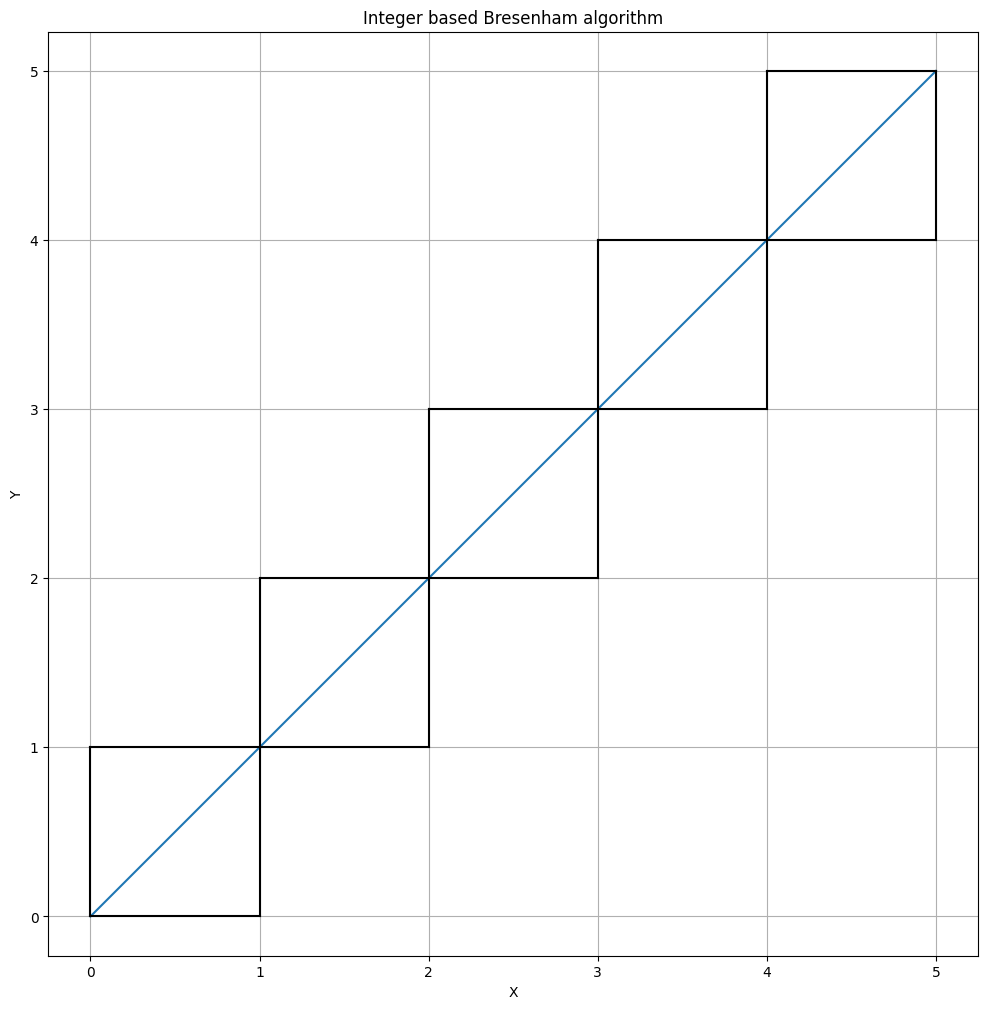

In [6]:
p1 = (0, 0)
p2 = (5, 5)

cells = bres(p1, p2, is_conservative=False)
#cells = bres(p1, p2, is_conservative=True)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]])


for q in cells:
    plt.plot([q[0], q[0]+1], [q[1], q[1]], 'k')
    plt.plot([q[0], q[0]+1], [q[1]+1, q[1]+1], 'k')
    plt.plot([q[0], q[0]], [q[1],q[1]+1], 'k')
    plt.plot([q[0]+1, q[0]+1], [q[1], q[1]+1], 'k')

plt.grid()
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Integer based Bresenham algorithm")
plt.show()

[(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5)]


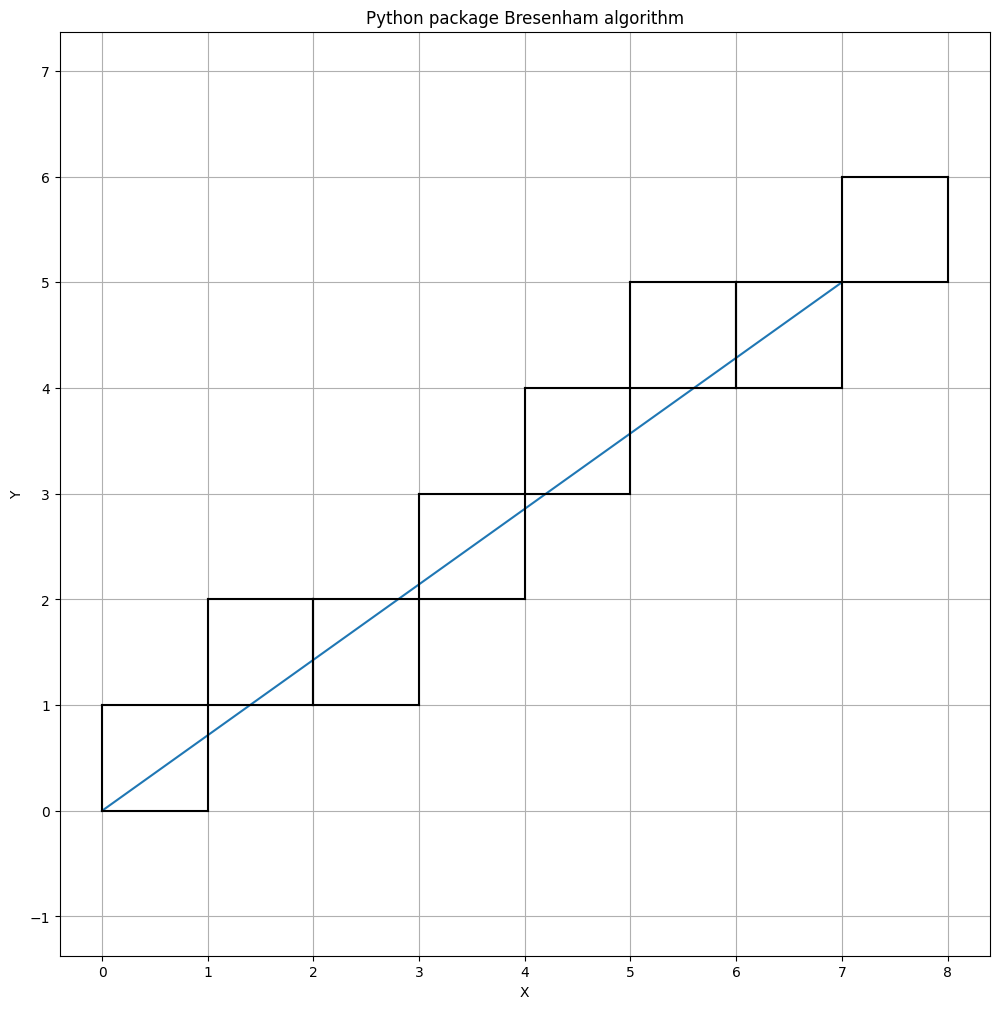

In [7]:
from bresenham import bresenham

line = (0, 0, 7, 5)

cells = list(bresenham(line[0], line[1], line[2], line[3]))
print(cells)

plt.plot([line[0], line[2]], [line[1], line[3]])


for q in cells:
    plt.plot([q[0], q[0]+1], [q[1], q[1]], 'k')
    plt.plot([q[0], q[0]+1], [q[1]+1, q[1]+1], 'k')
    plt.plot([q[0], q[0]], [q[1],q[1]+1], 'k')
    plt.plot([q[0]+1, q[0]+1], [q[1], q[1]+1], 'k')

plt.grid()
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Python package Bresenham algorithm")
plt.show()

## **$A^{*}$ with Colinearity**

In [8]:
filename = "../utils/map.csv"
data = np.loadtxt(filename, delimiter=',', dtype=np.float64, skiprows=2)

print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [9]:
drone_altitude = 5
safe_distance = 3
grid = create_grid(data, drone_altitude, safe_distance)

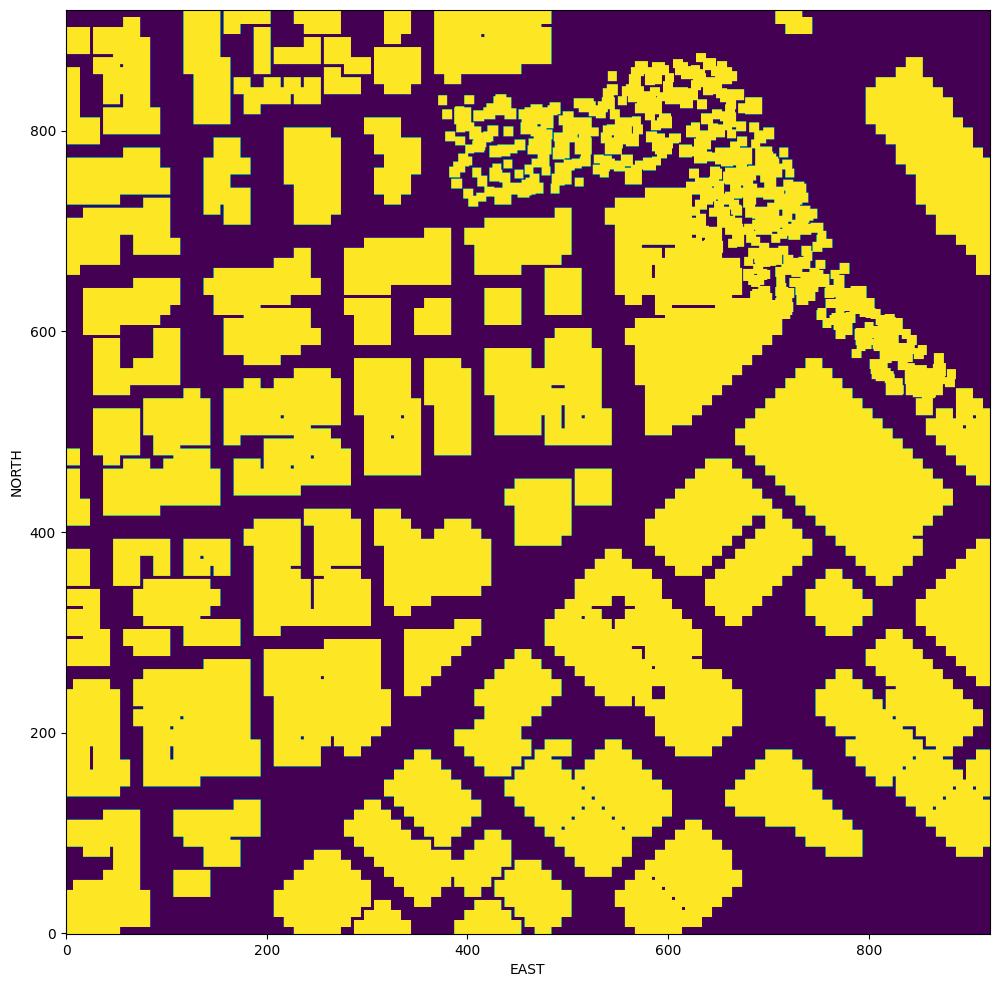

In [10]:
plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [11]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [12]:
def heuristic(position, goal_position):
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

def a_star(grid, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        current_cost, current_node = queue.get()
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))

    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

In [13]:
path_as, cost_as = a_star(grid, start_ne, goal_ne)
print(len(path_as), cost_as)

Found a path.
772 338563.454977574


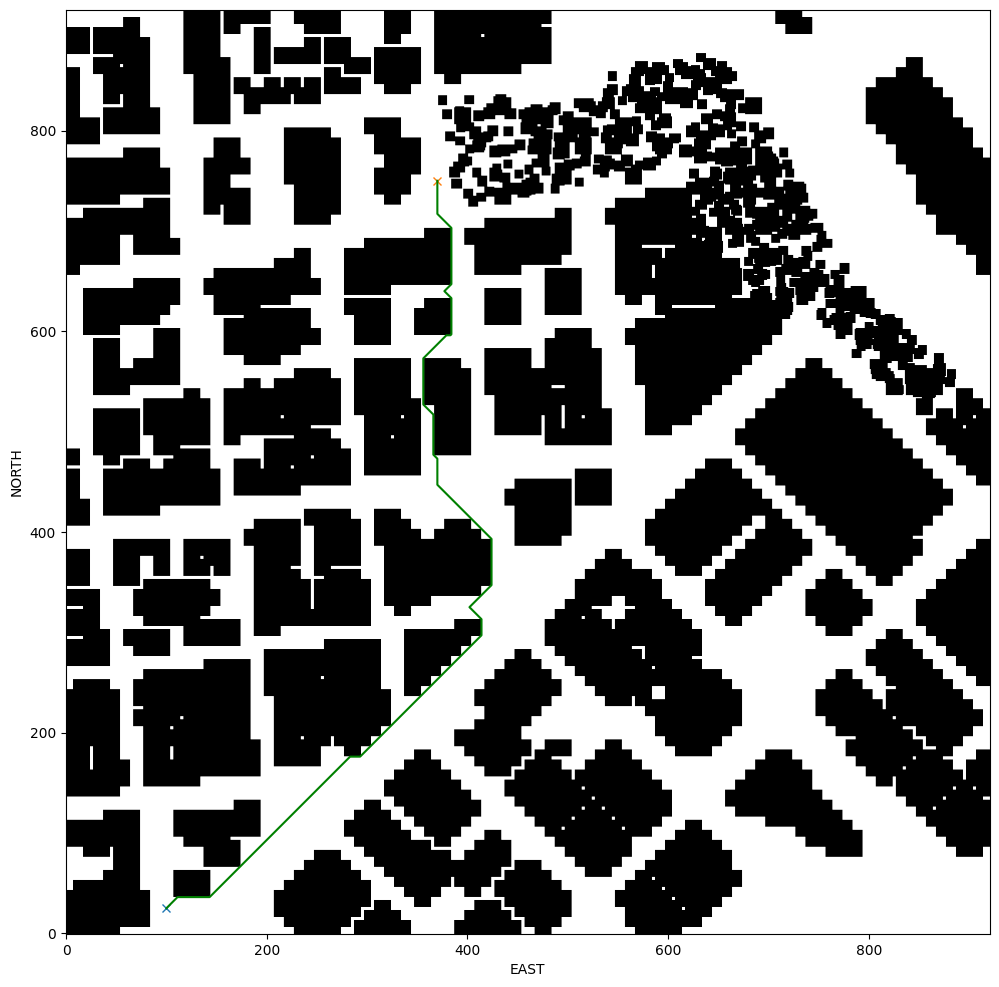

In [14]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path_as)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

#### **Path Pruning**

In [15]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

In [16]:
def prune_path(path):
    pruned_path = [p for p in path]
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])

        if collinearity_check(p1, p2, p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [17]:
pruned_path = prune_path(path_as)
print(len(pruned_path))

25


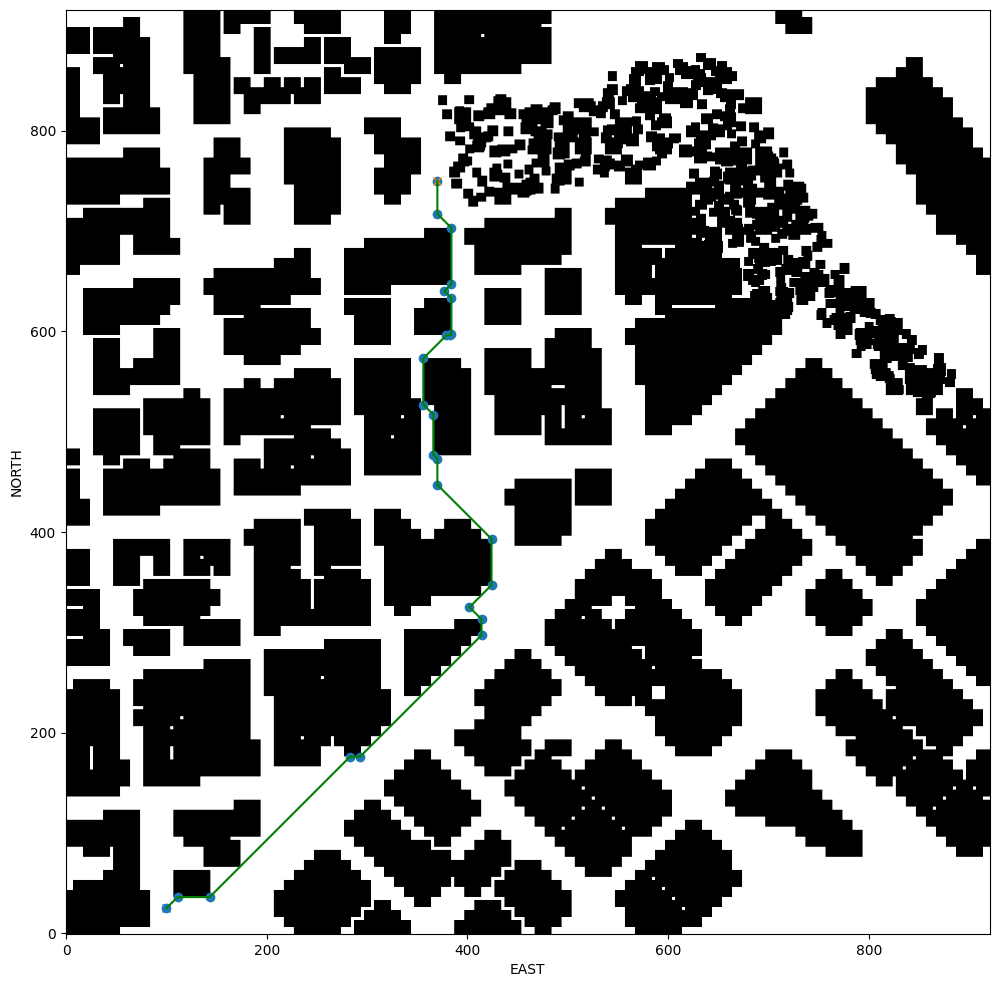

In [18]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
plt.scatter(pp[:, 1], pp[:, 0])
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

## Medial Axis

In [19]:
from skimage.morphology import medial_axis
from skimage.util import invert

In [20]:
start_ne = (25,  100)
goal_ne = (900, 100)
drone_altitude = 5
safety_distance = 2

In [21]:
grid = create_grid(data, drone_altitude, safety_distance)
skeleton = medial_axis(invert(grid))

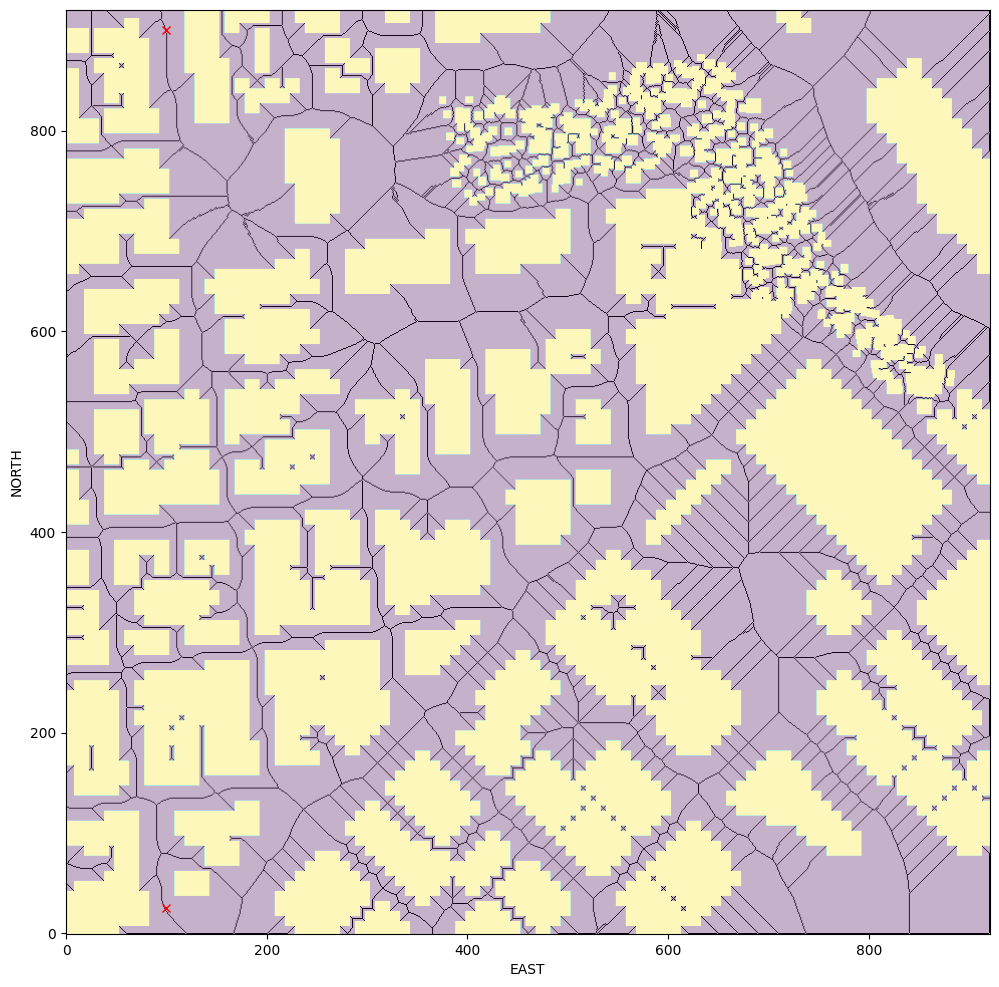

In [22]:
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [23]:
def find_start_goal(skel, start, goal):
    skel_cells = np.transpose(skel.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    
    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)

print(start_ne, goal_ne)
print(skel_start, skel_goal)

(25, 100) (900, 100)
[24 99] [900  99]


In [24]:
path_1, cost_1 = a_star(invert(skeleton).astype(np.int64), tuple(skel_start), tuple(skel_goal))
print("Path length = {0}, path cost = {1}".format(len(path_1), cost_1))

Found a path.
Path length = 982, path cost = 460794.08030253055


In [25]:
path_2, cost_2 = a_star(grid, start_ne, goal_ne)
print("Path length = {0}, path cost = {1}".format(len(path_2), cost_2))

Found a path.
Path length = 896, path cost = 409715.97979746724


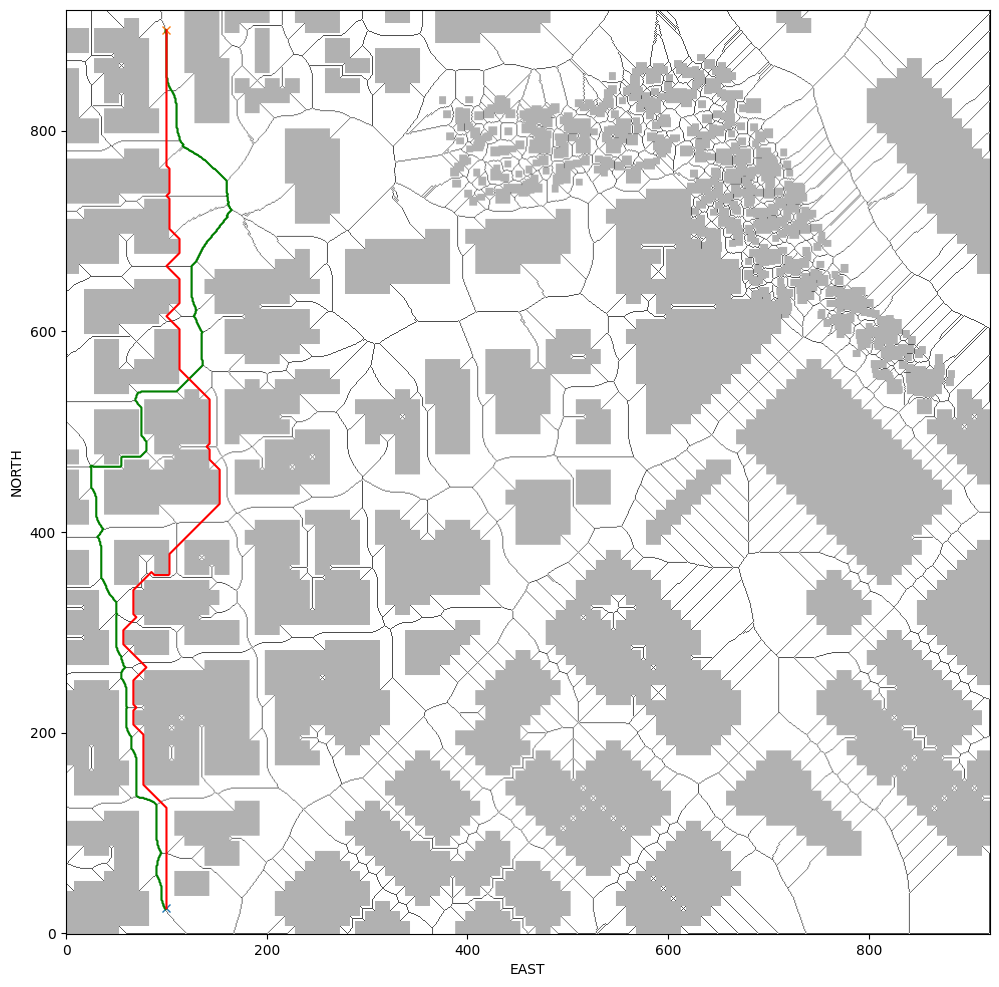

In [27]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp1 = np.array(path_1)
plt.plot(pp1[:, 1], pp1[:, 0], 'g')
pp2 = np.array(path_2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

# **Voronoi Graph**

In [28]:
from scipy.spatial import Voronoi, voronoi_plot_2d

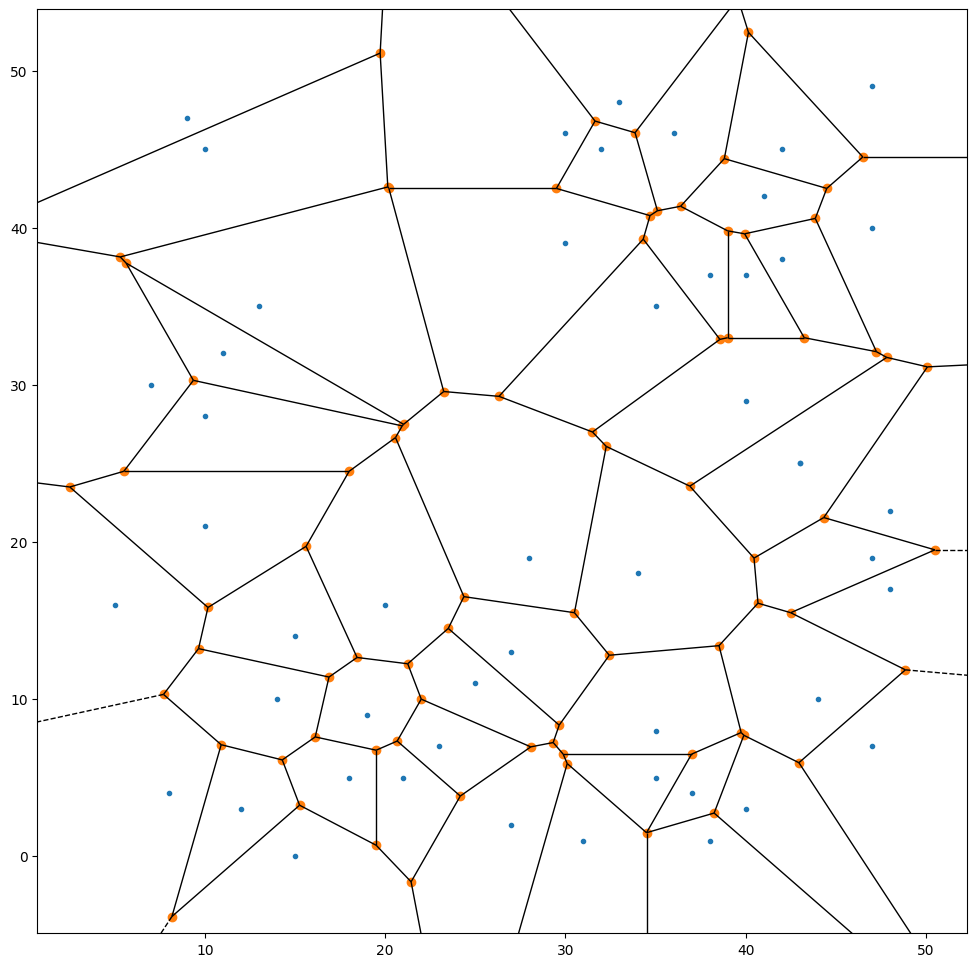

In [29]:
points = np.random.randint(50, size=(50, 2))
graph = Voronoi(points)

voronoi_plot_2d(graph)
plt.show()

In [30]:
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """

    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))
    grid = np.zeros((north_size, east_size))
    points = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            points.append([north - north_min, east - east_min])

    graph = Voronoi(points)
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        if not hit:
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))

    return grid, edges

In [31]:
drone_altitude = 5
safety_distance = 3
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)

print('Found %5d edges' % len(edges))

Found  1894 edges


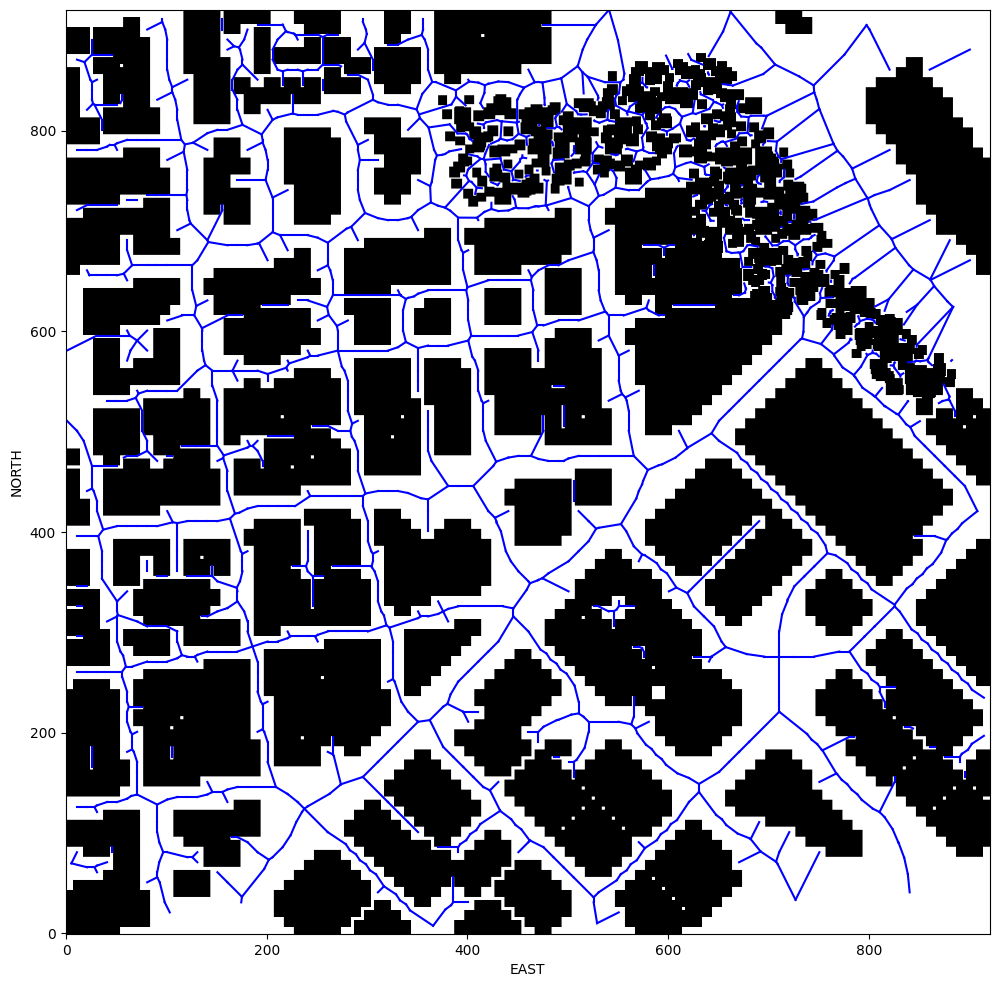

In [32]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

# **Graph Search**

In [40]:
import networkx as nx
import numpy.linalg as LA
from queue import PriorityQueue

In [39]:
G = nx.Graph()

for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

In [41]:
def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
                    
    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

In [42]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [43]:
start_ne_g = closest_point(G, start_ne)
goal_ne_g = closest_point(G, goal_ne)
print(start_ne_g)
print(goal_ne_g)

(np.float64(20.7611), np.float64(103.26850000000002))
(np.float64(748.7187188843021), np.float64(364.4144680930903))


In [44]:
path, cost = a_star(G, heuristic, start_ne_g, goal_ne_g)
print(len(path))

Found a path.
97


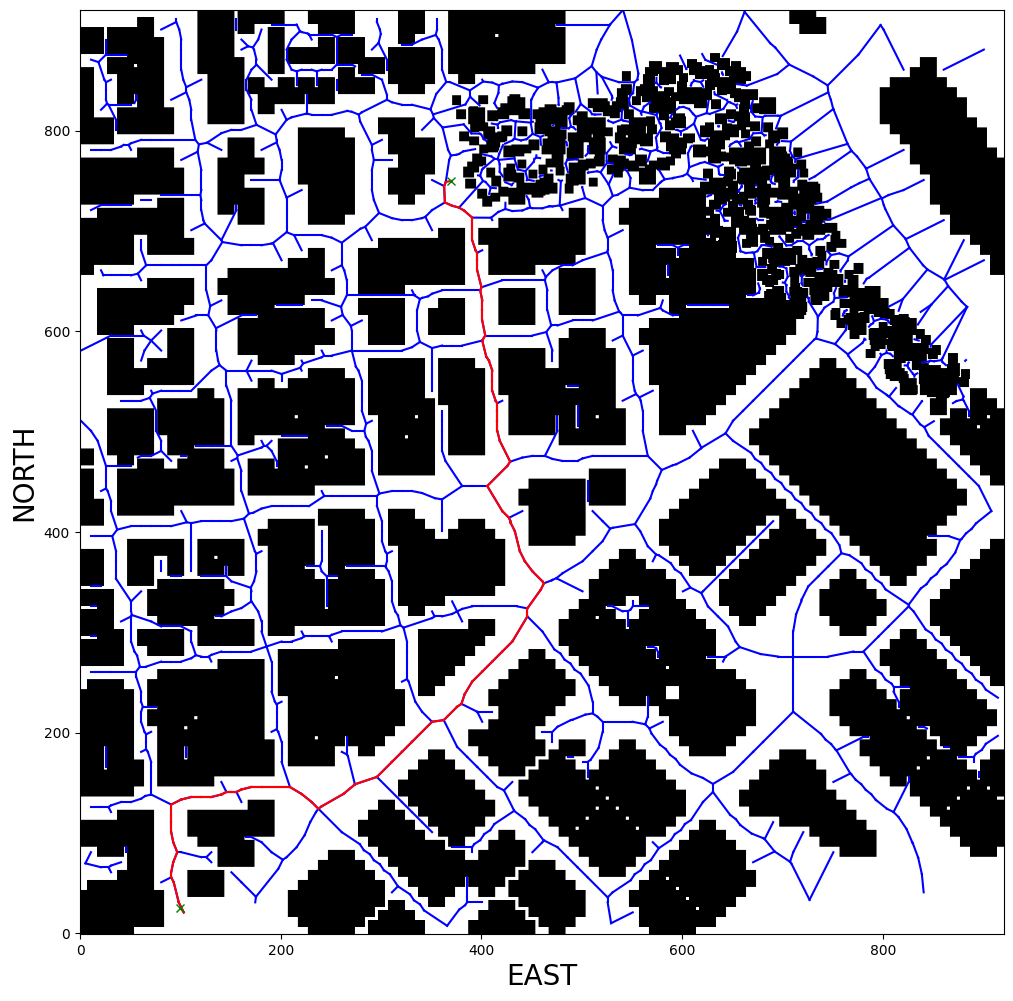

In [45]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()